<a href="https://colab.research.google.com/github/Eugeneantientropy/ML100Days/blob/main/HW_Day_86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

請參考範例程式碼Day086_CB_ModelCheckPoint.ipynb

作業１：試比較 save_best_only 與否的差異

作業２：請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

In [2]:
train, test = keras.datasets.cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 41s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [10]:
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5",  monitor="val_loss", save_best_only=True)

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [12]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer1 (Dense)                │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer2 (Dense)                │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer3 (Dense)                │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 3072))
  warnings.warn(msg)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2115 - loss: 2.4983

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.2128 - loss: 2.4925 - val_accuracy: 0.2242 - val_loss: 2.1542
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3885 - loss: 1.7747

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3886 - loss: 1.7741 - val_accuracy: 0.2899 - val_loss: 1.9769
Epoch 3/50
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4321 - loss: 1.6280

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4324 - loss: 1.6270 - val_accuracy: 0.3538 - val_loss: 1.8435
Epoch 4/50
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4575 - loss: 1.5536

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4578 - loss: 1.5525 - val_accuracy: 0.4055 - val_loss: 1.7149
Epoch 5/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4793 - loss: 1.4867

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4794 - loss: 1.4867 - val_accuracy: 0.4343 - val_loss: 1.6364
Epoch 6/50
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4968 - loss: 1.4513

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4969 - loss: 1.4507 - val_accuracy: 0.4440 - val_loss: 1.5852
Epoch 7/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5110 - loss: 1.4033

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5111 - loss: 1.4032 - val_accuracy: 0.4478 - val_loss: 1.5518
Epoch 8/50
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5218 - loss: 1.3704

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5220 - loss: 1.3701 - val_accuracy: 0.4657 - val_loss: 1.5154
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5371 - loss: 1.3363

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5371 - loss: 1.3363 - val_accuracy: 0.4716 - val_loss: 1.5016
Epoch 10/50
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5546 - loss: 1.2949

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5539 - loss: 1.2960 - val_accuracy: 0.4744 - val_loss: 1.4904
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5617 - loss: 1.2691 - val_accuracy: 0.4710 - val_loss: 1.5028
Epoch 12/50
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5699 - loss: 1.2468

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5699 - loss: 1.2470 - val_accuracy: 0.4818 - val_loss: 1.4790
Epoch 13/50
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5826 - loss: 1.2153

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5822 - loss: 1.2160 - val_accuracy: 0.4832 - val_loss: 1.4702
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5895 - loss: 1.1942

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5895 - loss: 1.1942 - val_accuracy: 0.4832 - val_loss: 1.4671
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6012 - loss: 1.1686 - val_accuracy: 0.4769 - val_loss: 1.4809
Epoch 16/50
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6071 - loss: 1.1499

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6069 - loss: 1.1498 - val_accuracy: 0.4909 - val_loss: 1.4528
Epoch 17/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6209 - loss: 1.1203

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6207 - loss: 1.1206 - val_accuracy: 0.4929 - val_loss: 1.4493
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6203 - loss: 1.1046 - val_accuracy: 0.4960 - val_loss: 1.4552
Epoch 19/50
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6324 - loss: 1.0836

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6322 - loss: 1.0836 - val_accuracy: 0.5011 - val_loss: 1.4463
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6386 - loss: 1.0588 - val_accuracy: 0.4989 - val_loss: 1.4544
Epoch 21/50
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6499 - loss: 1.0378

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6496 - loss: 1.0381 - val_accuracy: 0.5032 - val_loss: 1.4431
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6572 - loss: 1.0199 - val_accuracy: 0.4991 - val_loss: 1.4629
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6660 - loss: 0.9938 - val_accuracy: 0.4966 - val_loss: 1.4573
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6767 - loss: 0.9723 - val_accuracy: 0.4967 - val_loss: 1.4636
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6820 - loss: 0.9500 - val_accuracy: 0.5023 - val_loss: 1.4540
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6877 - loss: 0.9305 - val_accuracy: 0.5018 - val_loss: 1.4593
Epoch 27/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6938 - loss: 0.9157 - val_accuracy: 0.4952 - val_loss: 1.4730
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7069 - loss: 0.8904 - val_accuracy: 0.4970 - val_l

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5070 - loss: 1.4418


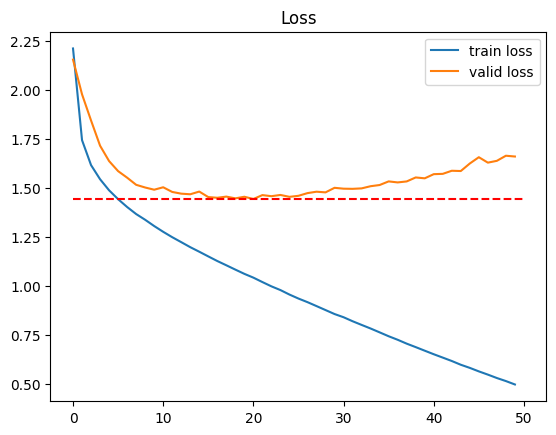

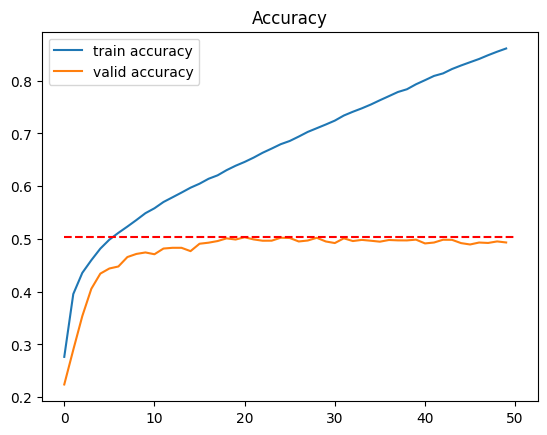

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [14]:
train, test = keras.datasets.cifar10.load_data()
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
model = keras.models.load_model("./tmp.h5")
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer1 (Dense)                │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer2 (Dense)                │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer3 (Dense)                │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,742,476 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 2 (12.00 B)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6559 - loss: 1.0175 - val_accuracy: 0.4942 - val_loss: 1.4637
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6591 - loss: 1.0066 - val_accuracy: 0.4943 - val_loss: 1.4714
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6693 - loss: 0.9796 - val_accuracy: 0.4999 - val_loss: 1.4641
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6786 - loss: 0.9556 - val_accuracy: 0.4978 - val_loss: 1.4618
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6863 - loss: 0.9402 - val_accuracy: 0.4964 - val_loss: 1.4612
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6911 - loss: 0.9240 - val_accuracy: 0.5013 - val_loss: 1.4726
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6996 - loss: 0.9049 - val_accuracy: 0.4991 - val_loss: 1.4748
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7103 - loss: 0.8808 - val_accuracy: 0.4992 - v

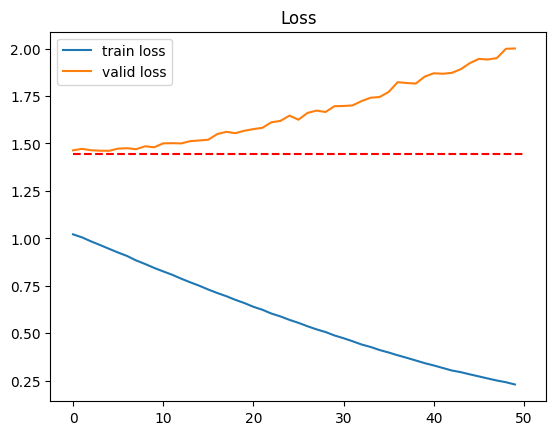

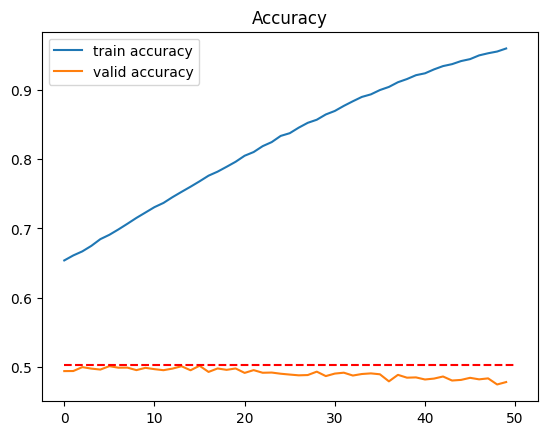

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()